# Module

In [1]:
module RecommenderSystems

using Distributions: Normal, mean
using LinearAlgebra: dot
using Random: shuffle
using SharedArrays: SharedArray
using Distributed#: @distributed, RemoteChannel
import Base.show

export Rating, MatrixFactorization, SVDModel, fit!, predict, score, splitcv, learningcurves, learningcurves2


"""
    Rating

User's rating of an item.
"""
mutable struct Rating
    item::Int64
    user::Int64
    value::Float64
end

function Base.show(io::IO, rating::Rating)
    fields = fieldnames(Rating)
    kwstr = join(["$(f)=$(getfield(rating, f))" for f in fields], ", ")
    print(io, "Rating($(kwstr))")
end


"""
    MatrixFactorization

Abstract supertype for matrix factorization based recommender systems models.
"""
abstract type MatrixFactorization end


"""
    SVDModel <: MatrixFactorization

SVD based recommender systems model.
"""
mutable struct SVDModel <: MatrixFactorization
    # Factorization
    P::Union{Matrix{Float64}, Nothing}
    Q::Union{Matrix{Float64}, Nothing}
    k::Int64
    
    # Initialization
    mean::Float64
    std::Float64
    
    # Baseline
    biased::Bool
    mu::Union{Float64, Nothing}
    bi::Union{Matrix{Float64}, Nothing}
    bu::Union{Matrix{Float64}, Nothing}
    
    # SGD
    nepochs::Int64
    lr::Float64
    reg::Float64
end


"""
    SVDModel(; <keyword arguments>)

# Arguments
- `k::Int64=10`: the number of factors.
- `mean::Float64=0.0`: mean of the normal distribution used to initialize the factorization matrices.
- `std::Float64=1e-4`: standard deviation of the normal distribution used to initialize the factorization matrices.
- `biased::Bool=true`: whether to use a baseline or not.
- `nepochs:::Int64=20`: number of epochs processed during stochastic gradient descent optimization.
- `lr::Float64=0.005`: learning rate used during gradient descent optimization.
- `reg::Float64=0.02`: regularization parameter used during gradient descent optimization.
"""
function SVDModel(;
        k::Int64=10,
        mean::Float64=0.0,
        std::Float64=1e-4,
        biased::Bool=true,
        nepochs::Int64=20,
        lr::Float64=0.005,
        reg::Float64=0.02)
    
    P = nothing
    Q = nothing
    mu = nothing
    bi = nothing
    bu = nothing
    
    SVDModel(P,Q,k,mean,std,biased,mu,bi,bu,nepochs,lr,reg)
end

function Base.show(io::IO, model::SVDModel)
    fields = [:k, :biased, :nepochs, :lr, :reg]
    kwstr = join(["$(f)=$(getfield(model, f))" for f in fields], ", ")
    print(io, "SVD($(kwstr),...)")
end


"""
    initbaseline(model::SVDModel, ratings::Vector{Rating}, nitems::Int64, nusers::Int64)

Initialize the baseline of the model according to the given ratings.
"""
function initbaseline(model::SVDModel, ratings::Vector{Rating})
    nitems = maximum(r.item for r in ratings)
    nusers = maximum(r.user for r in ratings)
    
    model.mu = mean(r.value for r in ratings)
    model.bi = zeros(nitems, 1)
    model.bu = zeros(1, nusers)
end


"""
    initnormal(model::SVDModel, ratings::Vector{Rating})

Create and initialize the factorization matrices of the SVD model according to the ratings.
"""
function initnormal(model::SVDModel, ratings::Vector{Rating})
    nitems = maximum(r.item for r in ratings)
    nusers = maximum(r.user for r in ratings)
    
    model.P = rand(Normal(model.mean, model.std), nitems, model.k)
    model.Q = rand(Normal(model.mean, model.std), nusers, model.k)
end


"""
    fit!(model::SVDModel, ratings::Vector{Ratings}; cb::Union{Function, Nothing}=nothing)

Fit the model by optimizing a regularized SSE(Summed Squared Error) through stochastic gradient descent.

If passed as the keyword argument `cb`, a callback function will be called at the end of each epoch
with arguments `nepoch::Int64` and `fcost::Float64`.
"""
function fit!(model::SVDModel, ratings::Vector{Rating}; cb::Union{Function, Nothing}=nothing)
    initnormal(model, ratings)
    model.biased && initbaseline(model, ratings)
    
    for epoch in 1:model.nepochs
        currentcost = 0
        for r in shuffle(ratings)
            pi = model.P[r.item,:]
            qu = model.Q[r.user,:]
            bi = model.bi[r.item]
            bu = model.bu[r.user]
            e = model.mu + bu + bi + dot(pi,qu) - r.value
            
            currentcost += abs2(e)
            
            model.P[r.item,:] -= model.lr * 2*(e*qu + model.reg*pi)
            model.Q[r.user,:] -= model.lr * 2*(e*pi + model.reg*qu)
            model.bi[r.item] -= model.lr * 2*(e + model.reg*bi)
            model.bu[r.user] -= model.lr * 2*(e + model.reg*bu)
        end
        
        if cb !== nothing
            cb(epoch, currentcost)
        end
    end
end


"""
    predict(model::SVDModel, item::Int64, user::Int64)

Predict the rating of an item by a user.
"""
function predict(model::SVDModel, item::Int64, user::Int64)
    if item > size(model.P, 1)
        pi = zeros(Float64, model.k)
        bi = 0.0
    else
        pi = model.P[item,:]
        bi = model.bi[item]
    end
        
    if user > size(model.Q, 1)
        qu = zeros(Float64, model.k)
        bu = 0.0
    else
        qu = model.Q[user,:]
        bu = model.bu[user]
    end

    model.mu + bi + bu + dot(pi, qu)
end


"""
    score(model::SVDModel, ratings::Vector{Rating})

Compute the score of the fitted model using SSE(Summed Squared Error).
"""
function score(model::SVDModel, ratings::Vector{Rating})
    sum(abs, (predict(model, r.item, r.user) - r.value) for r in ratings)
end


"""
    splitcv(ratings::Vector{Rating}; ratio::Float64=0.7)::NTuple{2, Vector{Rating}}

Split a vector of ratings into a training and test sets, according to a percentage ratio.
"""
function splitcv(ratings::Vector{Rating}; ratio::Float64=0.7)::NTuple{2, Vector{Rating}}
    idx = round(Int, length(ratings) * ratio)
    return (ratings[1:idx], ratings[idx+1:end])
end


"""
    learningcurves(model::SVDModel, train::Vector{Rating}, test::Vector{Rating}, step::Int64=1; cb::Union{Function, Nothing}=nothing)

Successively compute the train and test scores necessary to plot the learning curves of the model.
"""
function learningcurves(model::SVDModel, train::Vector{Rating}, test::Vector{Rating}, step::Int64=1; cb::Union{Function, Nothing}=nothing)
    sizes = collect(1:step:length(train))
    trainscores = SharedArray{Float64}(length(sizes))
    testscores = SharedArray{Float64}(length(sizes))
    
    done = RemoteChannel(() -> Channel{Bool}(32))

    @distributed for (i,s) in collect(enumerate(sizes))
        fit!(model, train[1:s])
        trainscores[i] = score(model, train[1:s])
        testscores[i] = score(model, test)
        put!(done, true)
    end
    
    for i in 1:length(sizes)
        take!(done)
        if cb !== nothing
            cb(i, length(sizes))
        end
    end
    
    return (sizes, trainscores, testscores)
end

end

Main.RecommenderSystems

### Write module to file

In [2]:
write("RecommenderSystems.jl", In[1])

6835

# Main

In [3]:
using .RecommenderSystems, PyCall, Distributed, Plots, IJulia

loadmat = pyimport("scipy.io")["loadmat"]
data = loadmat("ex8_movies.mat")
Y = convert(Array{Float64}, data["Y"]);

### Initialize workers

In [4]:
addprocs(3)
@everywhere push!(LOAD_PATH, ".")
@everywhere workers() using RecommenderSystems

### Destroy workers

In [13]:
rmprocs(workers())

Task (done) @0x00000001125621d0

### fit! test

In [ ]:
model = SVDModel(k=100, nepochs=100, lr=0.031, reg=0.0)
ratings = [Rating(ci.I[1], ci.I[2], Y[ci]) for ci in findall(x->x>0, Y)]
costs = Vector{Float64}(undef, 100)
@time fit!(model, ratings, cb=(epoch, cost) -> begin
    IJulia.clear_output(true)
    println("Processed epoch #$(epoch): $(cost)")
    costs[epoch] = cost
end)

plot(costs, xlabel="iterations", ylabel="cost", legend=false)

Processed epoch #100: 15.678544453658976
 64

### learningcurves test

In [9]:
ratings = [Rating(ci.I[1], ci.I[2], Y[ci]) for ci in findall(x->x>0, Y)]
trainset, testset = splitcv(ratings);

Trained 70/70
783.950774 seconds (2.14 M allocations: 51.703 MiB, 0.02% gc time)


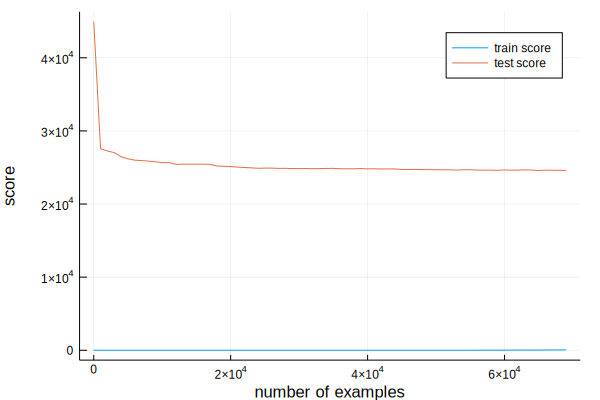

In [10]:
@time let model = SVDModel(k=100, nepochs=100, lr=0.031, reg=0.0)
    global sizes, trainscores, testscores = learningcurves(model, trainset, testset, 1000, cb=(index, total) -> begin
            IJulia.clear_output(true)
            println("Trained $(index)/$(total)")
            end)
end

plot(sizes, trainscores, xlabel="number of examples", ylabel="score", label="train score")
plot!(sizes, testscores, label="test score")

### Reminder

use `collect(enumerate` with `@distributed`!!!

### TODO

- in `fit!` method, use a dictionary in place of P and Q matrices.
- Validation curves function
- Random CV Search Function